<h1>Определение перспективного тарифа для телеком-компании</h1>


Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

**Тариф «Смарт»**
 - Ежемесячная плата: 550 рублей
 - Включено:
  - 500 минут разговора
  - 50 сообщений 
  - 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля
 - сообщение: 3 рубля
 - 1 Гб интернет-трафика: 200 рублей
 
**Тариф «Ультра»**
 - Ежемесячная плата: 1950 рублей
 - Включено:
  - 3000 минут разговора
  - 1000 сообщений 
  - 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль
 - сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей

## Обзор данных

Импорт библиотек и выгрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st


pd.set_option('display.max_columns', None)
np.set_printoptions(linewidth=110)
sns.set(rc={'figure.figsize':(19,10)})

In [2]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Таблицы. Головы и инфо

In [3]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица *calls* (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

**Проблемы**

- Столбец `call_date` требует изменения формата в `DateTime`

In [4]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Таблица *internet* (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

**Проблемы**

- Столбец `session_date` требует изменения формата в `DateTime`
- Присутствует столбец `Unnamed: 0`, он дублирует индексы, видимо артефакт выгрузки, нужно удалить

In [5]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица *messages* (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

**Проблемы**

- Столбец `message_date` требует изменения формата в `DateTime`

In [6]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица *tariffs* (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [7]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблица *users* (информация о пользователях):
user_id — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

**Проблемы**

- Столбцы `churn_date` и `reg_date` требует изменения формата в `DateTime`. Учитывая NaN'ы просто изменение формата возможно не пройдет с `churn_date`

### Вывод

- Пропусков в данных практически нет. Только даты прекращения пользования тарифом, но это связано с тем, что он действовал на момент выгрузки данных.
- В одной из таблиц сохранился дублирующий индекс столбец, который требуется удалить

## Предобработка данных

Для начала уберем дублирующий индекс столбец в `internet`

In [8]:
internet.drop('Unnamed: 0', inplace=True, axis=1)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Далее приведем даты к соответствующему формату

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [10]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [11]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [12]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Также переименуем столбец с названиями тарифов в `tariffs` для удобства последующего объединения

In [14]:
tariffs.rename({'tariff_name':'tariff'}, axis='columns', inplace=True)
tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')

### Подробный обзор данных
#### Calls

In [15]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [16]:
calls['id'].value_counts().unique()

array([1])

<AxesSubplot:>

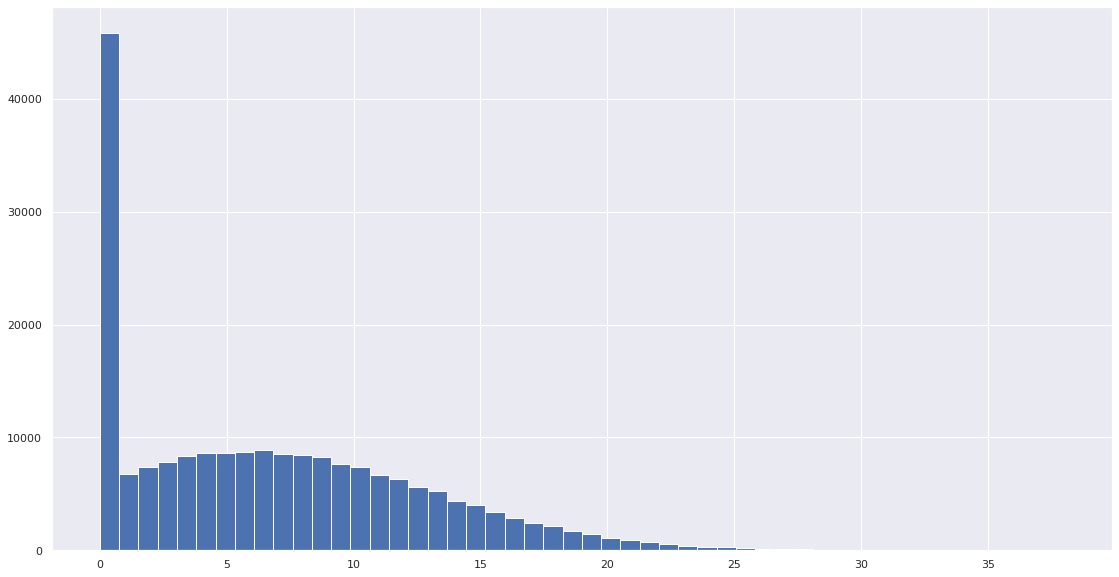

In [17]:
calls['duration'].hist(bins=50)

Как мы помним, в выгрузке присутствуют звонки с продолжительностью 0с. Для гистограммы возьмем срез `>0`

<AxesSubplot:>

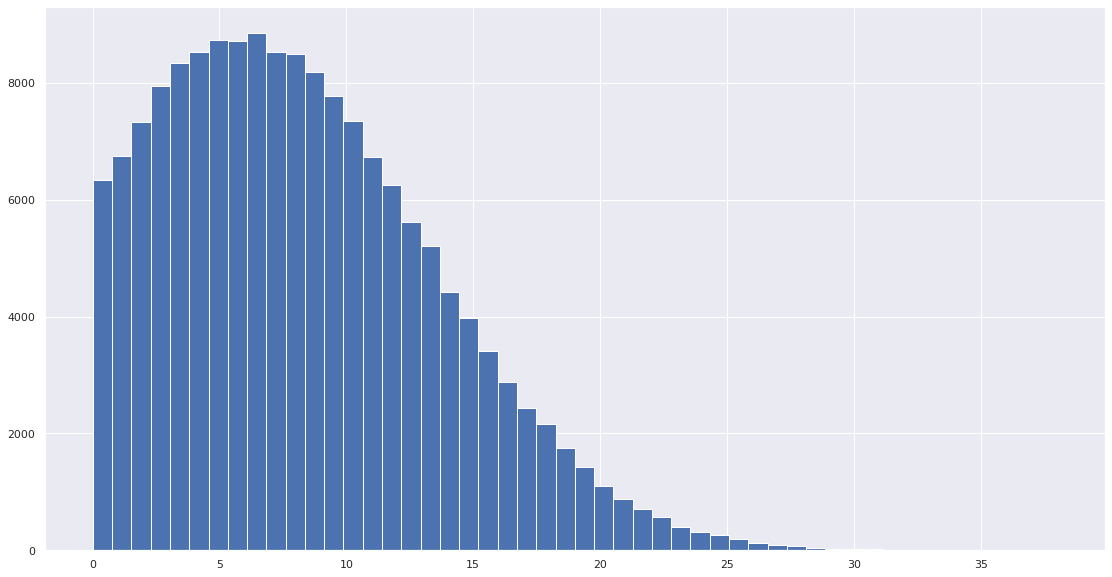

In [18]:
calls[calls['duration']>0]['duration'].hist(bins=50)

<AxesSubplot:>

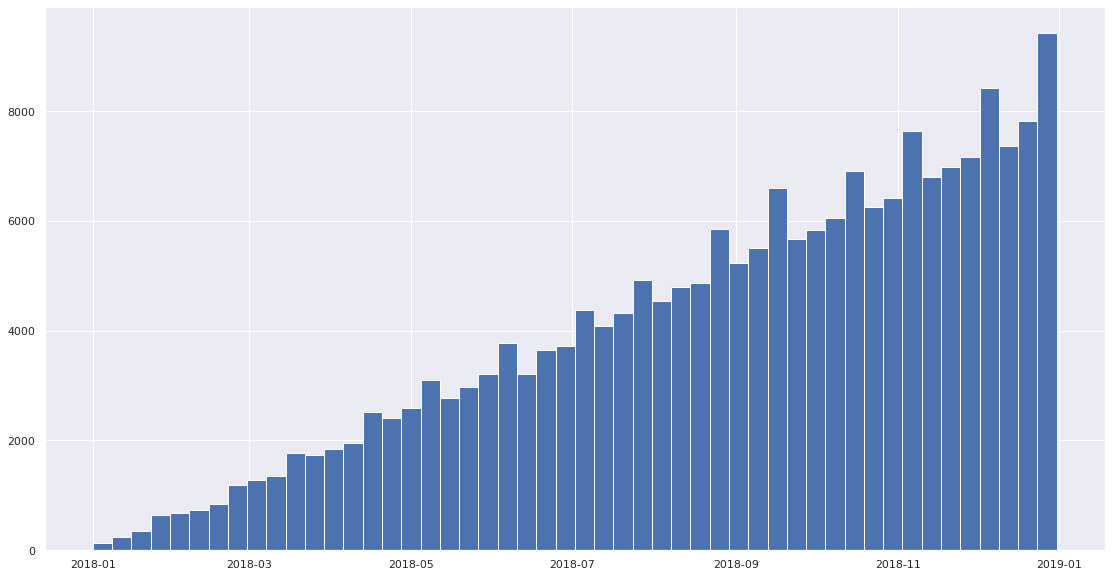

In [19]:
calls['call_date'].hist(bins=50)

#### Internet

In [20]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<AxesSubplot:>

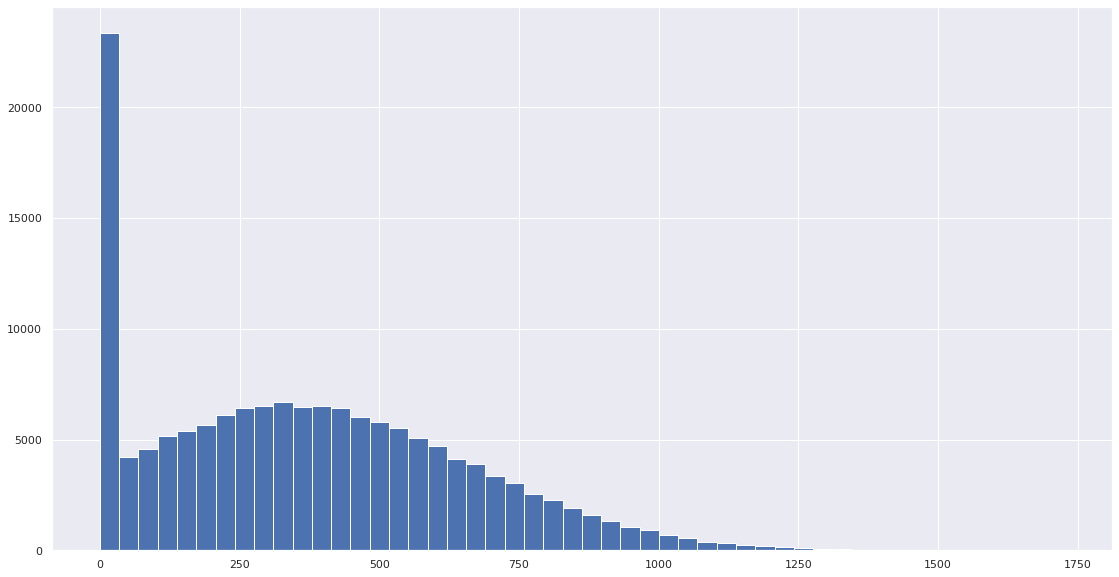

In [21]:
internet['mb_used'].hist(bins=50)

По аналогии берем условие `>0` не забывая, что есть люди, которые интернетом не пользовались

<AxesSubplot:>

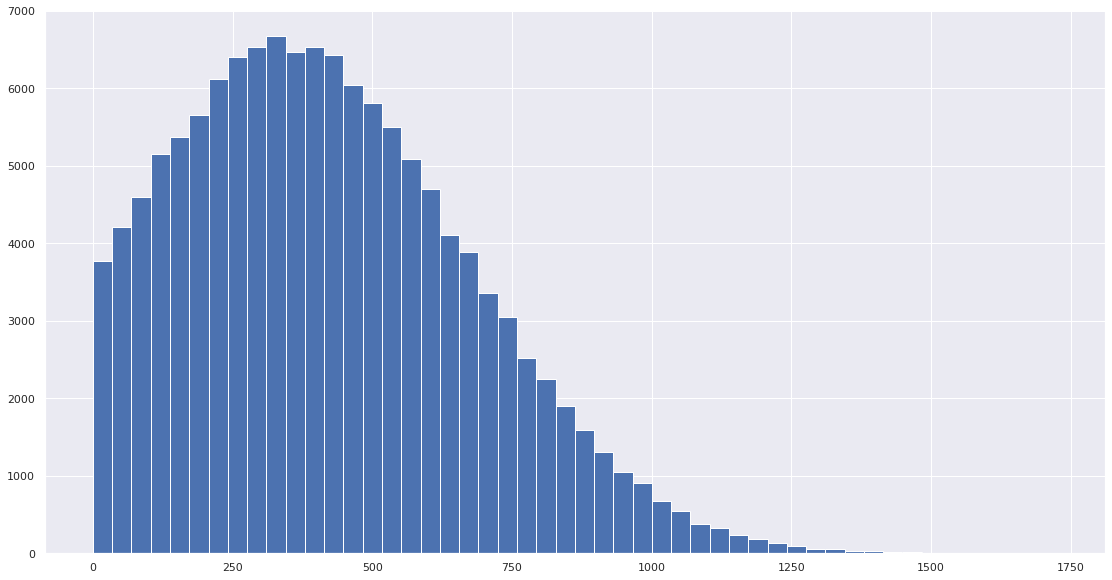

In [22]:
internet[internet['mb_used']>0]['mb_used'].hist(bins=50)

<AxesSubplot:>

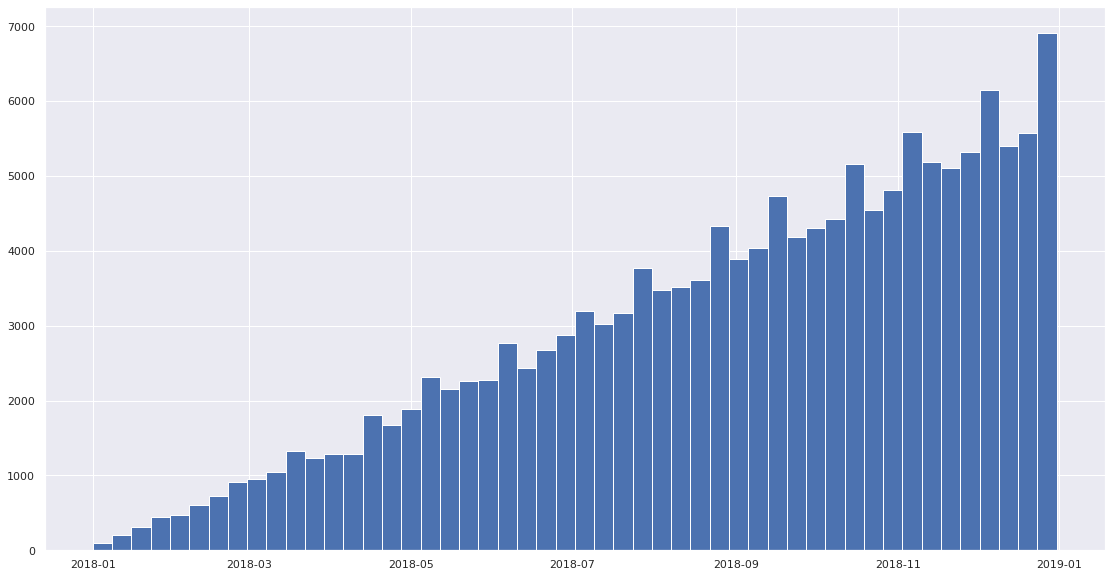

In [23]:
internet['session_date'].hist(bins=50)

#### Messages

In [24]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<AxesSubplot:>

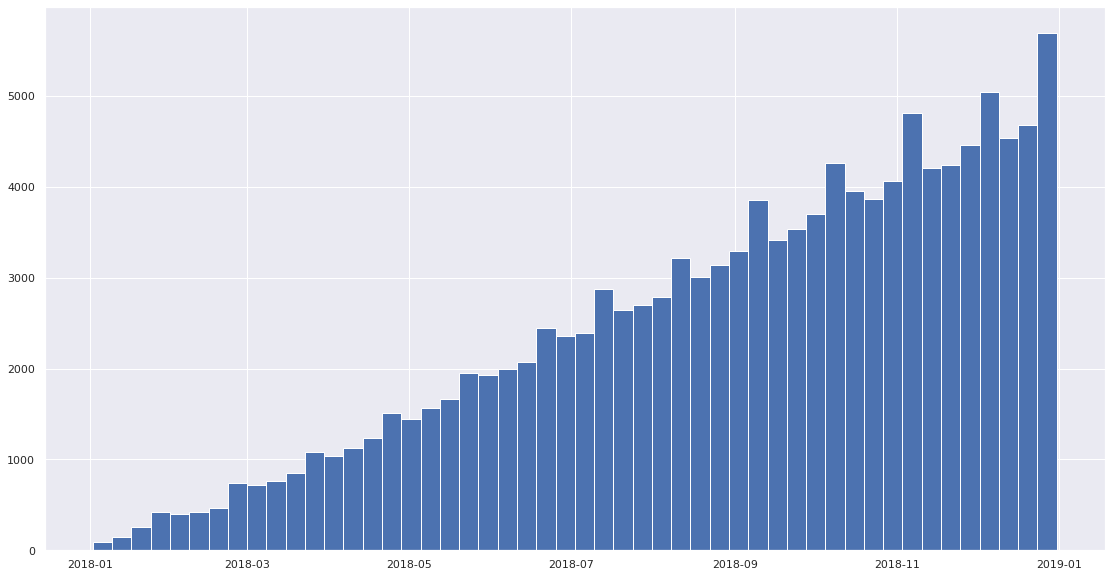

In [25]:
messages['message_date'].hist(bins=50)

#### Users

In [26]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [27]:
users['age'].sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75])

In [28]:
users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Иваново             1
Архангельск         1
Химки               1
Нижневартовск       1
Подольск            1
Name: city, Length: 76, dtype: int64

<AxesSubplot:>

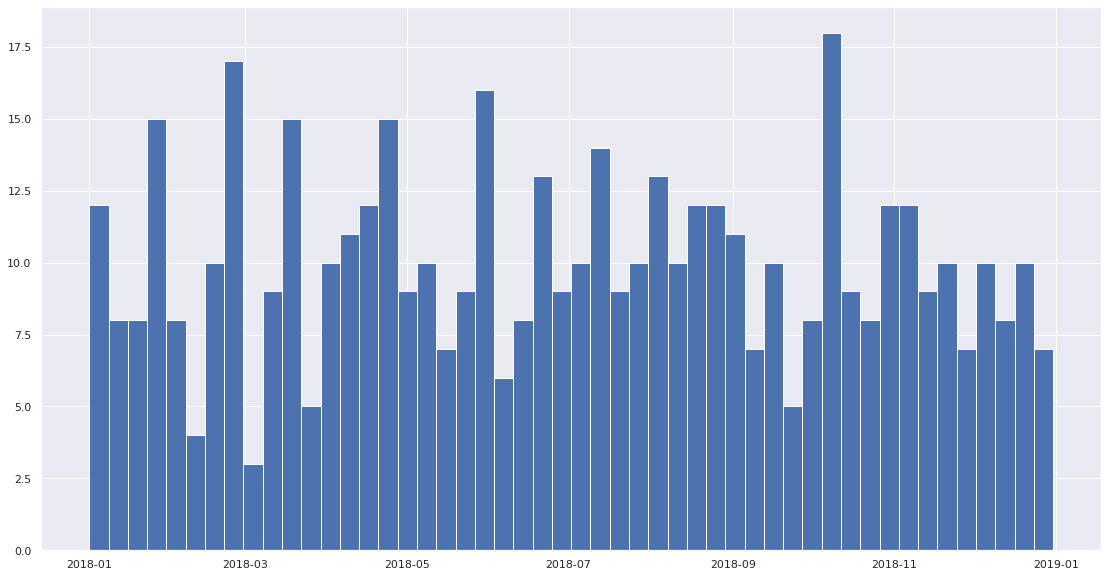

In [29]:
users['reg_date'].hist(bins=50)

In [30]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

#### Вывод

- Разбиение по тарифам ultra/smart 149/351
- Распределение по использованию тарифов пользователями напоминают нормальные без учета выбросов вызванных большим количеством людей, которые не пользовались какой-либо услугой либо пользовались очень мало.

## Подготовка данных

Создадим сводные таблицы по использованию траффика, звонков и смс пользователями по месяцам. 

Для этого выделим столбец не с полной датой, а с конкретным месяцем. Чтобы сохранить при этом формат заменим даты на первое число месяца, когда совершалось действие (совершен звонок, отправлено сообщение или интернет-сессия)

In [31]:
calls['month'] = calls['call_date'].to_numpy().astype('datetime64[M]')
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,2018-07-01
1,1000_1,2018-08-17,0.00,1000,2018-08-01
2,1000_2,2018-06-11,2.85,1000,2018-06-01
3,1000_3,2018-09-21,13.80,1000,2018-09-01
4,1000_4,2018-12-15,5.18,1000,2018-12-01


In [32]:
internet['month'] = internet['session_date'].to_numpy().astype('datetime64[M]')
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01


In [33]:
messages['month'] = messages['message_date'].to_numpy().astype('datetime64[M]')
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


Далее сводим промежуточные таблицы и добавляем столбцы с целыми гигабайтами и минутами для дальнейших расчетов

Перед подсчетом длительности звонков округлим длительности отдельных звонков до минут в соответствии с правилами тарифа.

In [34]:
calls['duration'] = calls['duration'].apply((np.ceil))
calls_agg = calls.groupby(['user_id','month'])['duration'].agg(['count','sum'])
calls_agg.head()

count    sum
user_id month                   
1000    2018-05-01     22  159.0
        2018-06-01     43  172.0
        2018-07-01     47  340.0
        2018-08-01     52  408.0
        2018-09-01     58  466.0

In [35]:
calls_agg.rename({'count':'calls_count',
                  'sum':'calls_sum'},
                 axis=1,
                 inplace=True)
calls_agg['calls_sum'] = np.ceil(calls_agg['calls_sum']).astype('int32')
calls_agg.head()

calls_count  calls_sum
user_id month                             
1000    2018-05-01           22        159
        2018-06-01           43        172
        2018-07-01           47        340
        2018-08-01           52        408
        2018-09-01           58        466

In [36]:
internet_agg = internet.groupby(['user_id','month'])['mb_used'].agg(['count','sum'])
internet_agg.head()

count       sum
user_id month                      
1000    2018-05-01      5   2253.49
        2018-06-01     49  23233.77
        2018-07-01     29  14003.64
        2018-08-01     29  14055.93
        2018-09-01     27  14568.91

In [37]:
internet_agg.rename({'count':'internet_count',
                  'sum':'internet_sum'},
                 axis=1,
                 inplace=True)
internet_agg['internet_sum'] = np.ceil(internet_agg['internet_sum']/1024).astype('int32')
internet_agg.head()

internet_count  internet_sum
user_id month                                   
1000    2018-05-01               5             3
        2018-06-01              49            23
        2018-07-01              29            14
        2018-08-01              29            14
        2018-09-01              27            15

In [38]:
messages_agg = (messages.
                groupby(['user_id','month']).
                agg('count')
               )
messages_agg.head()

id  message_date
user_id month                       
1000    2018-05-01  22            22
        2018-06-01  60            60
        2018-07-01  75            75
        2018-08-01  81            81
        2018-09-01  57            57

In [39]:
messages_agg.rename({'message_date':'message_count'}, axis=1, inplace=True)
messages_agg.drop('id', axis=1, inplace=True)
messages_agg.head()

message_count
user_id month                    
1000    2018-05-01             22
        2018-06-01             60
        2018-07-01             75
        2018-08-01             81
        2018-09-01             57

Выделим в `tariffs` столбец с целым количеством гигабайтов

In [40]:
tariffs['gb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).astype('int32')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


Объединяем таблицы по индексам

In [41]:
df = calls_agg.join([internet_agg, messages_agg], how='outer')
df = df.reset_index()
df.sample(10, random_state=2007)

,user_id,month,calls_count,calls_sum,internet_count,internet_sum,message_count
1977,1311,2018-12-01,42.0,300.0,50.0,16.0,76.0
1722,1273,2018-05-01,24.0,220.0,NaN,NaN,21.0
478,1076,2018-07-01,77.0,529.0,66.0,27.0,108.0
2423,1381,2018-01-01,59.0,382.0,33.0,15.0,32.0
2767,1430,2018-04-01,11.0,91.0,16.0,11.0,7.0
2703,1421,2018-12-01,40.0,335.0,55.0,15.0,36.0
2182,1344,2018-06-01,110.0,825.0,41.0,22.0,119.0
3036,1472,2018-04-01,87.0,590.0,59.0,18.0,60.0
1491,1233,2018-12-01,89.0,671.0,66.0,20.0,27.0
314,1050,2018-10-01,3.0,50.0,2.0,1.0,2.0


Добавляем информацию по пользователям и расшифровку тарифа для дальнейшего использования

In [42]:
df = df.merge(users, on='user_id', how='left')
df = df.merge(tariffs, on='tariff', how='left')
df

,user_id,month,calls_count,calls_sum,internet_count,internet_sum,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,2018-05-01,22.0,159.0,5.0,3.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
1,1000,2018-06-01,43.0,172.0,49.0,23.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
2,1000,2018-07-01,47.0,340.0,29.0,14.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
3,1000,2018-08-01,52.0,408.0,29.0,14.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
4,1000,2018-09-01,58.0,466.0,27.0,15.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,2018-10-01,41.0,247.0,59.0,21.0,42.0,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,15
3210,1499,2018-09-01,9.0,70.0,5.0,2.0,11.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15
3211,1499,2018-10-01,68.0,449.0,58.0,18.0,48.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15
3212,1499,2018-11-01,74.0,612.0,49.0,18.0,59.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15


Добавим столбец с выручкой с каждого пользователя

In [43]:
def income_func (row):
    gbs = (row['internet_sum']- row['gb_per_month_included']) * row['rub_per_gb']    #  Стоимость интернета сверх тарифа
    mins = (row['calls_sum']- row['minutes_included']) * row['rub_per_minute']       #  Стоимость звонков сверх тарифа
    sms = (row['message_count']- row['messages_included']) * row['rub_per_message']  #  Стоимость SMS сверх тарифа
    income = row['rub_monthly_fee'] + max(0, gbs) + max(0, mins) + max(0, sms)       #  Общая выручка с учетом того, что превышения по тарифу может и не быть
    return income

Построчно применяем функцию к датасету

In [44]:
df['income'] = df.apply(income_func, axis=1)
df.head()

,user_id,month,calls_count,calls_sum,internet_count,internet_sum,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,income
0,1000,2018-05-01,22.0,159.0,5.0,3.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
1,1000,2018-06-01,43.0,172.0,49.0,23.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
2,1000,2018-07-01,47.0,340.0,29.0,14.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
3,1000,2018-08-01,52.0,408.0,29.0,14.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
4,1000,2018-09-01,58.0,466.0,27.0,15.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30,1950.0


И, напоследок, избавимся от лишних столбцов, которые были нужны для подготовки данных и переименуем столбцы с потребленным объемом услуг

In [45]:
df.drop(['calls_count', 'internet_count', 'messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'gb_per_month_included'], axis=1, inplace=True)

In [46]:
df.rename({'calls_sum':'calls',
          'internet_sum':'internet',
          'message_count':'message'},
          axis='columns', inplace=True)

In [47]:
df.sample(10)

,user_id,month,calls,internet,message,age,churn_date,city,first_name,last_name,reg_date,tariff,income
1977,1311,2018-12-01,300.0,16.0,76.0,33,NaT,Тверь,Лолита,Крылова,2018-08-03,smart,828.0
1722,1273,2018-05-01,220.0,NaN,21.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1950.0
478,1076,2018-07-01,529.0,27.0,108.0,40,NaT,Уфа,Фёдор,Шарапов,2018-03-10,smart,3211.0
2423,1381,2018-01-01,382.0,15.0,32.0,64,NaT,Москва,Тамара,Серебрякова,2018-01-13,ultra,1950.0
2767,1430,2018-04-01,91.0,11.0,7.0,22,NaT,Тверь,Андрей,Авроров,2018-04-23,ultra,1950.0
2703,1421,2018-12-01,335.0,15.0,36.0,30,NaT,Калининград,Гайдар,Александрович,2018-02-22,smart,550.0
2182,1344,2018-06-01,825.0,22.0,119.0,60,NaT,Воронеж,Илзе,Игнатьева,2018-04-03,ultra,1950.0
3036,1472,2018-04-01,590.0,18.0,60.0,53,NaT,Ярославль,Наида,Боброва,2018-01-18,smart,1450.0
1491,1233,2018-12-01,671.0,20.0,27.0,28,NaT,Воронеж,Сара,Алфимова,2018-05-23,smart,2063.0
314,1050,2018-10-01,50.0,1.0,2.0,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,1950.0


И не забудем, конечно, заполнить пропуски в `calls, internet, message` на 0. Т.к. это просто указывает, что соответствующей услугой не пользовались.

In [48]:
df['calls'].fillna(0, inplace=True)
df['internet'].fillna(0, inplace=True)
df['message'].fillna(0, inplace=True)
df.isna().sum()

user_id          0
month            0
calls            0
internet         0
message          0
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
income           0
dtype: int64

## Анализ

Для начала разделим датафрейм на 2 поменьше, отдельные для пользователей каждого тарифа

In [49]:
df_smart = df[df['tariff'] == 'smart'].copy()
df_smart.reset_index(drop=True, inplace=True)
df_smart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     2229 non-null   int64         
 1   month       2229 non-null   datetime64[ns]
 2   calls       2229 non-null   float64       
 3   internet    2229 non-null   float64       
 4   message     2229 non-null   float64       
 5   age         2229 non-null   int64         
 6   churn_date  111 non-null    datetime64[ns]
 7   city        2229 non-null   object        
 8   first_name  2229 non-null   object        
 9   last_name   2229 non-null   object        
 10  reg_date    2229 non-null   datetime64[ns]
 11  tariff      2229 non-null   object        
 12  income      2229 non-null   float64       
dtypes: datetime64[ns](3), float64(4), int64(2), object(4)
memory usage: 226.5+ KB


In [50]:
df_ultra = df[df['tariff'] == 'ultra'].copy()
df_ultra.reset_index(drop=True, inplace=True)
df_ultra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     985 non-null    int64         
 1   month       985 non-null    datetime64[ns]
 2   calls       985 non-null    float64       
 3   internet    985 non-null    float64       
 4   message     985 non-null    float64       
 5   age         985 non-null    int64         
 6   churn_date  76 non-null     datetime64[ns]
 7   city        985 non-null    object        
 8   first_name  985 non-null    object        
 9   last_name   985 non-null    object        
 10  reg_date    985 non-null    datetime64[ns]
 11  tariff      985 non-null    object        
 12  income      985 non-null    float64       
dtypes: datetime64[ns](3), float64(4), int64(2), object(4)
memory usage: 100.2+ KB


array([[<AxesSubplot:title={'center':'calls'}>, <AxesSubplot:title={'center':'internet'}>],
       [<AxesSubplot:title={'center':'message'}>, <AxesSubplot:title={'center':'income'}>]], dtype=object)

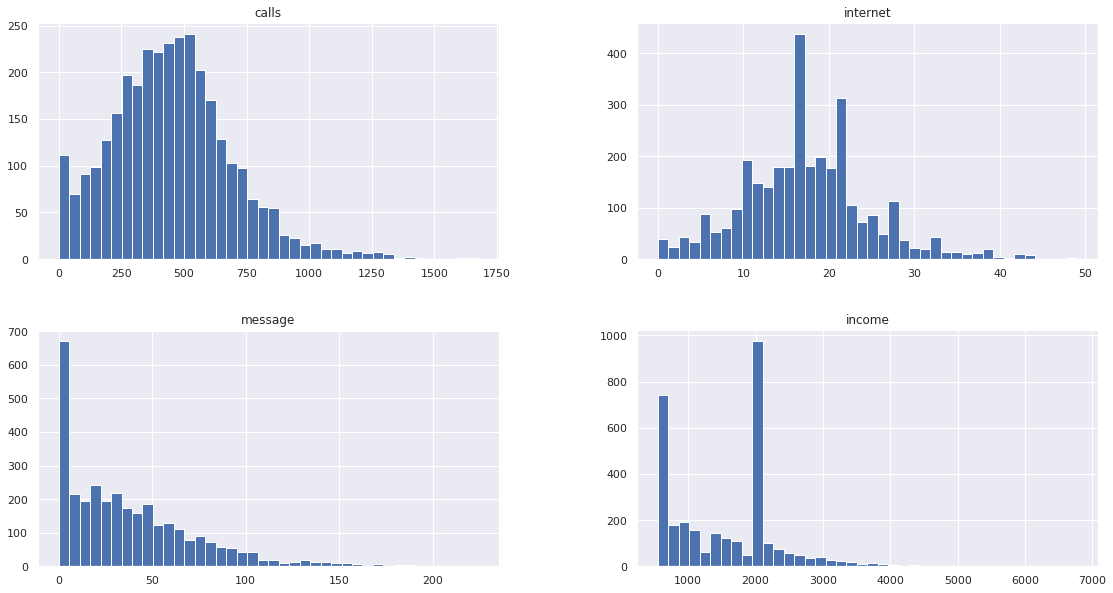

In [51]:
df.hist(['calls','internet', 'message','income'], bins=40);

array([[<AxesSubplot:title={'center':'calls'}>, <AxesSubplot:title={'center':'internet'}>],
       [<AxesSubplot:title={'center':'message'}>, <AxesSubplot:title={'center':'income'}>]], dtype=object)

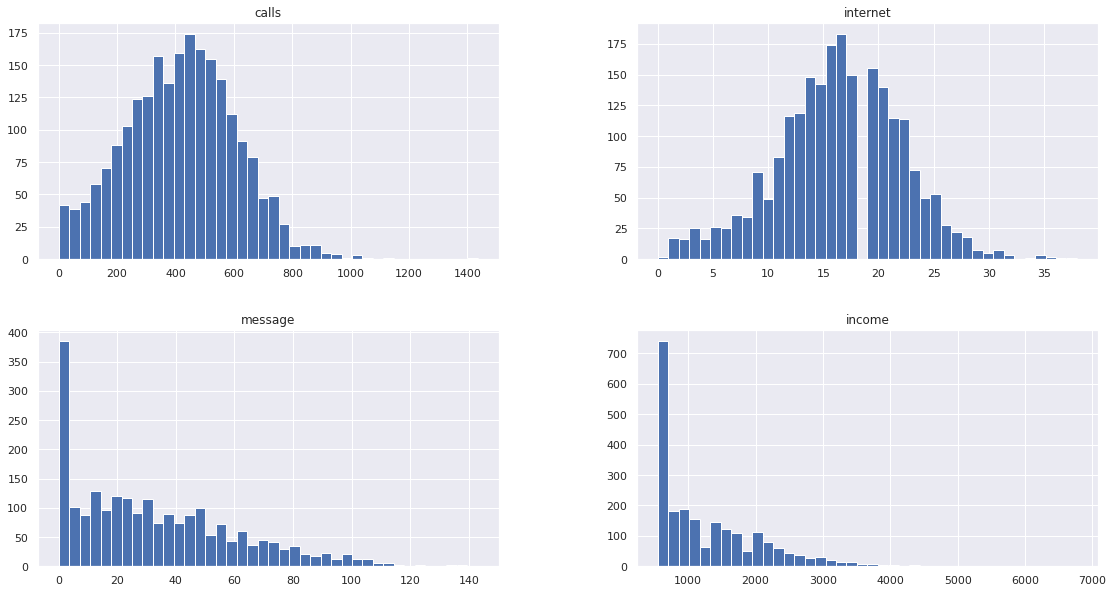

In [52]:
df_smart.hist(['calls','internet', 'message','income'], bins=40);

array([[<AxesSubplot:title={'center':'calls'}>, <AxesSubplot:title={'center':'internet'}>],
       [<AxesSubplot:title={'center':'message'}>, <AxesSubplot:title={'center':'income'}>]], dtype=object)

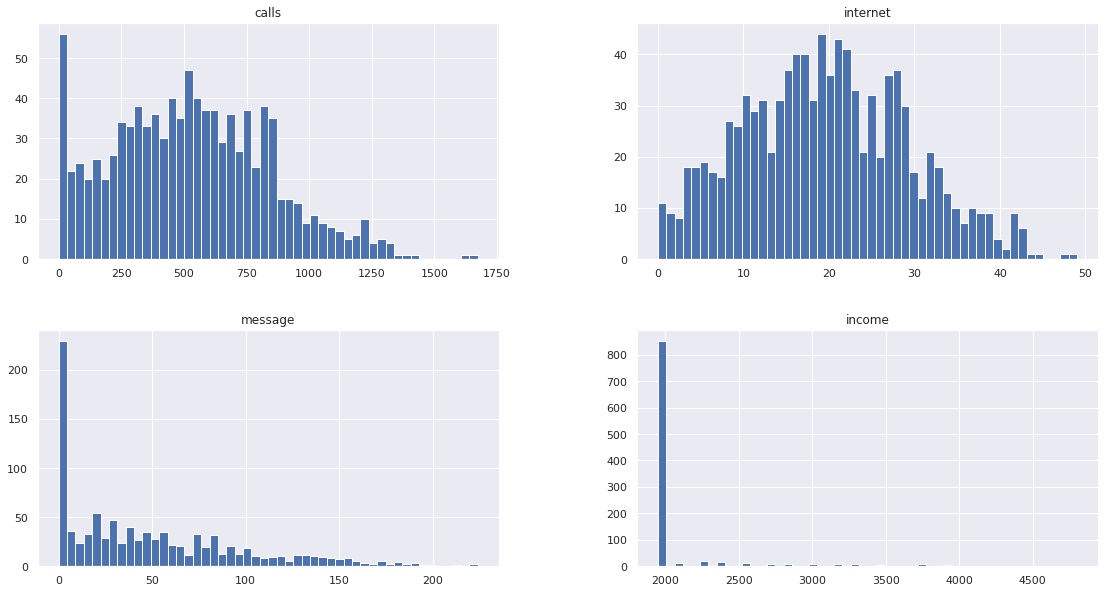

In [53]:
df_ultra.hist(['calls','internet', 'message','income'], bins=50);

Посчитаем средние, дисперсию и стандартное отклонение

In [54]:
pivot = df.groupby('tariff')['calls','internet', 'message','income'].agg('mean')
pivot

/tmp/ipykernel_98/19930750.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = df.groupby('tariff')['calls','internet', 'message','income'].agg('mean')


,calls,internet,message,income
tariff,,,,
smart,417.934948,16.328847,33.384029,1289.973531
ultra,526.623350,19.494416,49.363452,2070.152284


In [55]:
pivot = df.groupby('tariff')['calls','internet', 'message','income'].agg('std')
pivot

/tmp/ipykernel_98/196698494.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = df.groupby('tariff')['calls','internet', 'message','income'].agg('std')


,calls,internet,message,income
tariff,,,,
smart,190.313730,5.747061,28.227876,818.404367
ultra,317.606098,9.853511,47.804457,376.187114


In [56]:
pivot = df.groupby('tariff')['calls','internet', 'message','income'].agg('var')
pivot

/tmp/ipykernel_98/2097932920.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = df.groupby('tariff')['calls','internet', 'message','income'].agg('var')


,calls,internet,message,income
tariff,,,,
smart,36219.315784,33.028705,796.812958,669785.708006
ultra,100873.633397,97.091686,2285.266143,141516.745079


- Распределения похожи на нормальные
- Звонки и сообщения смещены влево
- Стандартное отклонение `smart` велико (если сравнивать со стоимостью самого тарифа). Это связано с нередкими превышениями использования услуг сверх стандартных пакетов.
- В среднем выручка с пользователя `smart`'а значительно (более чем в 2 раза) больше стоимости самого тарифа

<AxesSubplot:xlabel='month'>

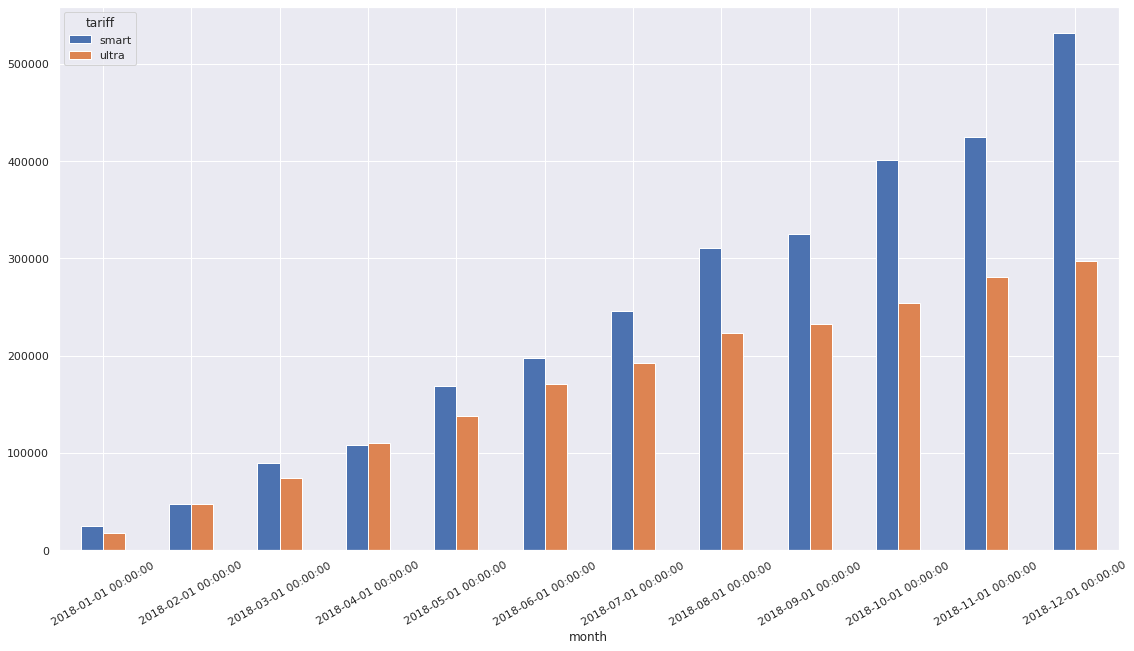

In [57]:
pivot = df.pivot_table(index='month', columns='tariff', values='income', aggfunc='sum')

pivot.plot(kind='bar',rot=30)

- Выручка стабильно растет. Это не может не радовать!
- Выручка по `ultra` растет значительно быстрее

## Проверка гипотез
### Гипотеза №1

**Гипотеза**

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

**Вводные**
- Т.к. в обеих выборках по тарифам количество значений нельзя назвать недостаточным t-test проводить можно
- По той же причине можно не приводить выборки одного размера
- Пороговым значением возьмем 0,01. Размеры выборок позволяют задать такую точность

**Гипотезы для теста**

- *нулевая* - средние выручки равны
- *альтернативная* - не равны


In [ ]:
smart = df_smart['income']
ultra = df_ultra['income']

alpha = .01

results = st.ttest_ind(
    smart, 
    ultra)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

#### Вывод

Результат проведенного теста позволяет гипотезу отвергнуть.

### Гипотеза №2

**Гипотеза**
Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Гипотезы для теста**

- *нулевая* - средние выручки равны
- *альтернативная* - не равны


In [ ]:
msk = df[df['city'] == 'Москва']
other = df[df['city'] != 'Москва']

msk.info()
other.info()

Размеры выборок позволяют провести тест

In [ ]:
alpha = .01

results = st.ttest_ind(msk['income'],
                       other['income'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Проведенный тест не позволяет утверждать, что средняя выручка с пользователя из Москвы и регионов отличается. 

Значит и структура разделения пользователей по тарифам если и отличается, то не фатально.

#### Вывод

Средняя выручка пользователей из Москвы и из регионов значительно не отличаются

## Вывод

- **Выручка стабильно растет**
- **Выручка по `ultra` растет значительно быстрее**


- Распределение по использованию тарифов пользователями напоминают нормальные без учета выбросов вызванных большим количеством людей, которые не пользовались какой-либо услугой либо пользовались очень мало.

- Ни на одном из тарифов в среднем польностью не используются пакеты минут и SMS
- Пользователи `smart` в среднем не укладываются в предоставленный пакет интернет трафика.

***После анализа данных и проверки статистических гипотез можно сказать что для бизнеса тариф `ultra` интереснее т.к. приносит больше выручки несмотря на то, что пользователи `smart` часто не укладываются в заложенные в тариф пакеты и оплачивают дополнительные. Поэтому больший упор в рекламных компаниях имеет смысл сделать на `ultra`, `smart` же должен привлекать новых клиентов и давать возможность "распробовать" оператора и, возможно, дополнительные фичи, которые он предоставляет чтобы в дальнейшем использование более дорого тарифа ощущалось оправданным и понятным***